# Gaussian Mixture Models Implementation

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

Since we do not have any real data, we generate it randomly from normal distributions using the below fuction.

In [142]:
def generate_random_sample(nbr_gaussian, nbr_observ):
    
    samples = []
    sample_tuples = []
    parameters = []
    size = int(nbr_observ/nbr_gaussian)
    for x in range(nbr_gaussian):
        mean, sd = random.randint(-30, 30), random.randint(1, 3)
        samples.append(np.random.normal(loc=mean, scale=sd, size=size))
        parameters.append((mean, sd))
        sample_tuples.append((mean, samples[x]))
        
    print('Parameters of the random distributions: ' +str(parameters))
    samples_array = np.array([x for sample_x in samples for x in sample_x])
    
    return {'parameters': parameters, 'X': samples_array.reshape((len(samples_array), 1)), 'samples': samples, 'samp_tup': sample_tuples}

In [143]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

Let us now implement the Gaussian density function. Ahem... I know you can use numpy functions for that, but I believe it is actually interesting to see how things work internally. Our aim is to create a function that implements this:

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


__Step 1__

This is the initialization step of the GMM. At this point, we must initialise our parameters $\pi_k$, $\mu_k$, and $\Sigma_k$. In this case, we are going to use the results of KMeans as an initial value for $\mu_k$, set $\pi_k$ to one over the number of clusters and $\Sigma_k$ to the identity matrix. We could also use random numbers for everything, but using a sensible initialisation procedure will help the algorithm achieve better results.

In [144]:
def initialize_clusters(X, nbr_cluster):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(nbr_cluster, n_init = 100).fit(X)
    
    cluster_id = kmeans.labels_
    
    mu_k = kmeans.cluster_centers_
        
    for i in range(nbr_cluster):
        clusters.append({
            'pi_k': 1.0 / nbr_cluster,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters, cluster_id

**Step 2 (Expectation step)**

We should now calculate $\gamma(z_{nk})$. We can achieve this by means of the following expression:

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

For convenience, we just calculate the denominator as a sum over all terms in the numerator, and then assign it to a variable named __totals__

In [145]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

**Step 3 (Maximization step):**

Let us now implement the maximization step. Since $\gamma(z_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$, we can simply define:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

And then we can calculate the revised parameters by using:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

Note: To calculate the covariance, we define an auxiliary variable __diff__ that contains $(x_n-\mu_k)^T$.

In [146]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
    Q = []
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0) 
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k
        
        Q_K = np.sum(np.multiply(gamma_nk, np.log(pi_k)))


Let us now determine the log-likelihood of the model. It is given by:

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

However, the second summation has already been calculated in the __expectation_step__ function and is available in the __totals__ variable. So we just make use of it.

In [147]:
def get_likelihood(X, clusters):
    smpl_likelihood = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(smpl_likelihood), smpl_likelihood

Finally, let's put everything together! First, we are going to initialise the parameters by using the __initialise_clusters__ function, and then perform several expectation-maximization steps. In this case, we set the number of iterations of the training procedure to a fixed __nbr_epoch__ number. I have done this on purpose to generate graphs of the log-likelihood later.

In [148]:
def train_gmm(X, nbr_cluster, nbr_epoch):
    
    clusters, cluster_id = initialize_clusters(X, nbr_cluster)
    likelihoods = np.zeros((nbr_epoch, ))
    scores = np.zeros((X.shape[0], nbr_cluster))
    history = []

    for i in range(nbr_epoch):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, smpl_likelihood = get_likelihood(X, clusters)
        likelihoods[i] = likelihood
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
    return clusters, likelihoods, scores, smpl_likelihood, history, cluster_id

# Find the best number of Gaussians

The below function estimates the fit error of each gaussian using the Kolmogorov–Smirnov test (stats.ks_2samp). It returns the Kolmogorov–Smirnov test values and the parameters of each Gaussian (mean and standard deviation)

In [149]:
def compare(sol, clusters, nbr_cluster, nbr_observ, clusters_X):
    
    bins = 50
    fitness = []
    parameters = []
    
    for i in range(nbr_cluster):
        
        X = clusters_X[clusters_X[:,1] == i][:,0]    
    size = int(nbr_observ/nbr_cluster)
    for n in range(nbr_cluster):
        mean = float(clusters[n]['mu_k'])
        standard_deviation = np.sqrt(float(clusters[n]['cov_k']))
           
        X = clusters_X[clusters_X[:,1] == n][:,0]
        rvs1 = stats.norm.rvs(size=size, loc=mean, scale=standard_deviation)
        fitness.append(stats.ks_2samp(rvs1, X)[0])
        x_values = np.arange(-50, 50, 0.01)
        y_values = stats.norm(mean, standard_deviation)
                
        parameters.append((mean, standard_deviation))
        
    return np.mean(fitness), parameters


In [150]:
def show_best(X,nbr_cluster):
    left, right = min(X), max(X)
    nbr_epoch = 2
    clusters, likelihoods, scores, smpl_likelihood, history, clusters_X = train_gmm(X, nbr_cluster, nbr_epoch)
    clusters_X = clusters_X.reshape((len(clusters_X), 1))
    clusters_X =  np.column_stack((X, clusters_X))
    
    bins = 20
 
    plt.figure(figsize=(15, 6), dpi=80)
    for i in range(nbr_cluster):
        
        X = clusters_X[clusters_X[:,1] == i][:,0] 
        plt.hist(X, density=True, bins = bins, alpha = 0.4)[0]
    
    
    size = int(nbr_observ/nbr_cluster)
    for n in range(nbr_cluster):
        mean = float(clusters[n]['mu_k'])
        standard_deviation = np.sqrt(float(clusters[n]['cov_k']))
           
        X = clusters_X[clusters_X[:,1] == n][:,0]
        rvs1 = stats.norm.rvs(size=size, loc=mean, scale=standard_deviation)
        x_values = np.arange(left*1.2, right*1.2, 0.01)
        y_values = stats.norm(mean, standard_deviation)
        
        plt.plot(x_values, y_values.pdf(x_values), linewidth=4)
        
    
    plt.show()
    
    

In [151]:
def gaussian_mixture(X, max_gaussians = 10):
    nbr_observ = len(X)
    fitness = []
    parameters = []
    for i in range(max_gaussians):
        nbr_cluster = i+1
        nbr_epoch = 2
        clusters, likelihoods, scores, smpl_likelihood, history, clusters_X = train_gmm(X, nbr_cluster, nbr_epoch)
        clusters_X = clusters_X.reshape((len(clusters_X), 1))
        clusters_X =  np.column_stack((X, clusters_X))
        fit, param = compare(sol, clusters, nbr_cluster, nbr_observ, clusters_X)
        fitness.append(fit)
        parameters.append(param)
    best_nbr_cluster = fitness.index(min(fitness))+1
    best_parameters = parameters[fitness.index(min(fitness))]
    print('The best Nº of Guassian fits is ' + str(fitness.index(min(fitness))+1))
    print('The paramters are: ' + str(parameters[fitness.index(min(fitness))]))
    print('The fit looks like: ')
    show_best(X,best_nbr_cluster)
    
    return parameters[fitness.index(min(fitness))]

Parameters of the random distributions: [(24, 2), (3, 1), (15, 3), (-20, 3), (8, 2)]
The best Nº of Guassian fits is 2
The paramters are: [(12.498222597028187, 8.13261737732611), (-20.053888359131136, 2.8716887323797717)]
The fit looks like: 


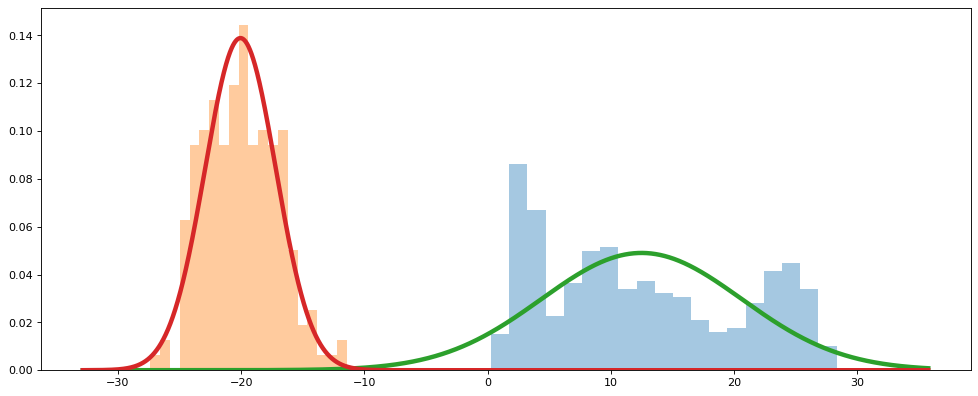

In [152]:
nbr_gaussian = 5
nbr_observ = 1000
sol = generate_random_sample(nbr_gaussian,nbr_observ)
X = sol['X']

parameters = gaussian_mixture(X)

In [158]:
# !pip install hyperactive

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
#from sklearn.model_selection import cross_val_score
#from sklearn.ensemble import GradientBoostingClassifier
from hyperactive import Hyperactive
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

In [159]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

iris = datasets.load_iris()
features = iris.data
target = iris.target

<ipython-input-161-5c5082a5d03b>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


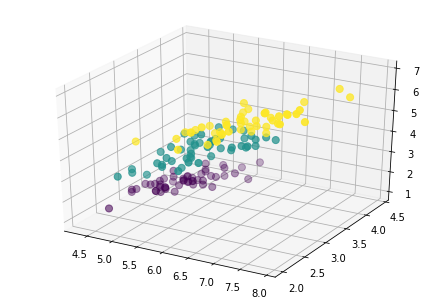

In [161]:
scaler = StandardScaler()
features_std = scaler.fit_transform(features)

fig = plt.figure()
ax = Axes3D(fig)#, auto_add_to_figure=False
fig.add_axes(ax)
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=target, s=50)
plt.show()

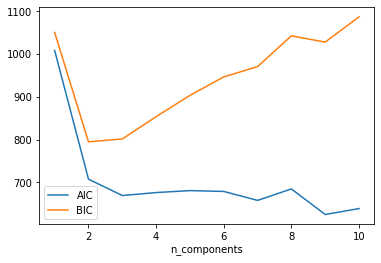

In [162]:
n_components = np.arange(1, 11)
models = [GMM(n, covariance_type='full', random_state=0).fit(features_std) for n in n_components]

plt.plot(n_components, [m.aic(features_std) for m in models], label='AIC')
plt.plot(n_components, [m.bic(features_std) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')

plt.show()

In [168]:
def model(opt):
    gmm = GMM(
        n_components=opt["n_components"],
        covariance_type =opt["cov_type"],
        init_params = opt["params"],
    ).fit(features_std)

    scores = gmm.bic(features_std)

    return scores.mean()

search_space = {
    "n_components": list(range(1, 11, 1)),
    "cov_type": ['full', 'tied', 'diag', 'spherical'],
    "params": ['kmeans', 'random'],
}

hyper = Hyperactive()
hyper.add_search(model, search_space, n_iter=40)
hyper.run()


Results: 'model'  
   Best score: 1742.8113221986773  
   Best parameter set:
      'n_components' : 1  
      'cov_type'     : diag  
      'params'       : kmeans  
   Best iteration: 28  
 
   Random seed: 1646008862  
 
   Evaluation time   : 0.6882951259613037 sec    [91.41 %]
   Optimization time : 0.06470298767089844 sec    [8.59 %]
   Iteration time    : 0.7529981136322021 sec    [53.12 iter/sec]
 


(150, 4)
The best Nº of Guassian fits is 1
The paramters are: [(-1.4684549872375404e-15, 1.0000000000000002)]
The fit looks like: 


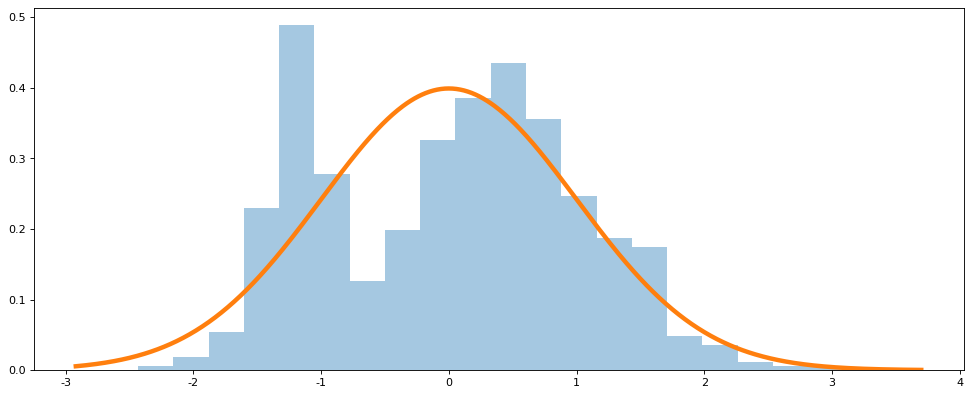

In [184]:
print(features_std.shape)
parameters = gaussian_mixture(features_std.reshape(features_std.shape[0]*features_std.shape[1],1))